# Prep

In [0]:
# ONLY FOR GOOGLE COLABORATORY, OTHERWISE RUN IT LOCALLY.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !pip install xlsxwriter

     |████████████████████████████████| 143kB 2.7MB/s 


In [0]:
# import required libraries
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import time
from openpyxl.reader.excel import load_workbook
%matplotlib inline

In [0]:
path = '/content/drive/My Drive/World Bank/Siap Tanggap/Data/'
path_output = '/content/drive/My Drive/World Bank/Siap Tanggap/Output/'
# convert downloaded files to csv (or excel but you gotta change the code) file first! 
# the downloaded file is a xml file, so pandas can't read it.

# filename
OT = 'OT.csv' # One-Time questionnaire
WK = 'Weekly.csv' # Weekly questionnaire
MT = 'Monthly.csv' # Monthly questionnaire
SHP = 'semarang_kelurahan.csv' # Indonesia shp file in 2016 per Desa/Kelurahan, from Edith
rw_list = "RW.xlsx" # from Jeremia

In [0]:
# formatting data
def formatdf(df):
  # stripping whitespaces
  df['Kecamatan'] = df['Kecamatan'].str.strip()
  df['Kelurahan'] = df['Kelurahan'].str.strip()
  # change RT values to integer, previously was float
  df.RT = df.RT.astype(int)
  # get rid of empty columns
  print("no of columns before dropping: {}".format(len(df.columns)))
  df.dropna(how='all', axis=1, inplace=True)
  print("no of columns after dropping: {}".format(len(df.columns)))

  return df

## GIS shapefile *keys

In [0]:
# open list of RW excel file
rwlist = pd.read_excel(path+rw_list)
rwlist['Kecamatan'] = rwlist['Kecamatan'].str.strip()
rwlist['Kelurahan'] = rwlist['Kelurahan'].str.strip()
kelurahan_list = rwlist[["Kecamatan","Kelurahan"]].drop_duplicates(subset=["Kecamatan","Kelurahan"])
kelurahan_list.reset_index(inplace=True)
kelurahan_list.drop(columns=["index"], inplace=True)
len(kelurahan_list)

177

In [0]:
# open shp table attribute file
shp = pd.read_csv(path+SHP)
shp["KECAMATAN"] = shp.KECAMATAN.str.title()
shp["DESA"] = shp.DESA.str.title()
shp = shp[['KECAMATAN', 'DESA', 'IDDESA']]

In [0]:
def replace_name(mode,kecamatan,name,kelurahan=None):
  """
  This function change the name of the shp table attribute so it can be merged.
  mode: 'kec' to change kecamatan name and 'kel' to change kelurahan name
  kecamatan: designated kecamatan to be replaced (according to shp file)
  kelurahan: designated kelurahan to be replaced (according to shp file), fill None if mode is 'kec'
  name: name to be replaced in kecamatan/kelurahan (string)
  """
  if mode == "kec":
    shp['kec_siap'][shp['kec_siap']==kecamatan] = name
  elif mode == "kel":
    shp['kel_siap'][(shp['kec_siap']==kecamatan)&(shp['kel_siap']==kelurahan)] = name
  else:
    print("Mode should be written as 'kec' or 'kel'")
  return shp

In [0]:
shp['kec_siap'] = shp['KECAMATAN']
shp['kel_siap'] = shp['DESA']
# Kecamatans to be renamed
change_kec = [["Gunung Pati","Gunungpati"],["Gajah Mungkur","Gajahmungkur"]]
for kec in range(0,len(change_kec)):
  shp = replace_name('kec',change_kec[kec][0],change_kec[kec][1])

# Kelurahans to be renamed
change_kel = [["Semarang Selatan",'Mugassari', 'Mugasari'],
              ["Pedurungan",'Plamongan Sari', 'Plamongansari'],
              ['Gayamsari','Sawahbesar','Sawah Besa'],
              ['Gayamsari','Tambakrejo','Tambakharjo'],
              ['Semarang Utara','Tanjungmas','Tanjung Mas'],
              ['Semarang Barat','Ngemplaksimongan','Ngemplak Simongan'],
              ['Semarang Barat','Bojongsalaman','Bojong Salaman'],
              ['Semarang Barat','Salamanmloyo','Salaman Mloyo'],
              ['Semarang Barat','Tambak Harjo','Tambakharjo'],
              ['Semarang Barat','Tawangsari','Tawang Sari'],
              ['Semarang Barat','Karang Ayu','Karanganyu'],
              ['Semarang Barat','Tawangmas','Tawang Mas'],
              ['Tugu','Jerakah','Jrakah'],
              ['Tugu','Randu Garut','Randugarut'],
              ['Mijen','Kedungpani','Kedungpane'],
              ['Gajahmungkur','Karang Rejo','Karangrejo'],
              ['Gunungpati','Sumurejo','Sumurrejo'],
              ['Gunungpati','Pungangan','Pongangan'],
              ['Gayamsari','Sawah Besa','Sawah Besar']]
for kel in range(0,len(change_kel)):
  shp = replace_name('kel',change_kel[kel][0],change_kel[kel][2],change_kel[kel][1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [0]:
# merge both dataframe
shp_code = pd.merge(kelurahan_list, shp,  how='outer', 
                    left_on=['Kecamatan','Kelurahan'], 
                    right_on=['kec_siap','kel_siap'])
shp_code.drop(columns=shp_code.columns[0:4],inplace=True)
print(len(shp_code))
shp_code.columns)

177
Index(['IDDESA', 'kec_siap', 'kel_siap'], dtype='object')


## One Time Data

In [0]:
ot = pd.read_csv(path+OT)
ot = formatdf(ot)
ot.head(2)

In [0]:
# put IDDESA as a *key to shapefile
print("before merging: {}".format(ot.shape))
ot = pd.merge(ot, shp_code,  how='outer', left_on=['Kecamatan','Kelurahan'], right_on=['kec_siap','kel_siap'])
ot.drop(columns=ot.columns[-2:],inplace=True)
print("after merging: {}".format(ot.shape))

before merging: (4132, 10)
after merging: (4132, 11)


## Weekly data

In [0]:
wk = pd.read_csv(path+WK)
wk = formatdf(wk)
wk.head(1)

In [0]:
# put IDDESA as a *key to shapefile
print("before merging: {}".format(wk.shape))
wk = pd.merge(wk, shp_code,  how='inner', left_on=['Kecamatan','Kelurahan'], right_on=['kec_siap','kel_siap'])
wk.drop(columns=wk.columns[-2:],inplace=True)
print("after merging: {}".format(wk.shape))

before merging: (3769, 23)
after merging: (3769, 24)


## Monthly data

In [0]:
mt = pd.read_csv(path+MT)
mt = formatdf(mt)
mt.head(1)

In [0]:
# put IDDESA as a *key to shapefile
print("before merging: {}".format(mt.shape))
mt = pd.merge(mt, shp_code,  how='inner', left_on=['Kecamatan','Kelurahan'], right_on=['kec_siap','kel_siap'])
mt.drop(columns=mt.columns[-2:],inplace=True)
print("after merging: {}".format(mt.shape))

before merging: (3533, 67)
after merging: (3533, 68)


# Recapitulation

In [0]:
# Count the number of RW per Kelurahans
rwlist = pd.merge(rwlist, shp_code,  how='outer', left_on=['Kecamatan','Kelurahan'], 
                  right_on=['kec_siap','kel_siap'])
rwlist.drop(columns=rwlist.columns[-2:],inplace=True)
allRWperKEL = rwlist.groupby(['IDDESA','Kecamatan','Kelurahan'])[['RW']].count()
allRWperKEL.reset_index(inplace=True)

In [0]:
def RTcounter(df):
  """
  Count the frequency of RT's submission
  df: downloaded data
  """
  data = {"IDDESA":[],"Kecamatan":[],"Kelurahan":[],"RW":[],"RT":[],"Frequency":[]}
  for id in df["IDDESA"].unique():
    for rw in df[df["IDDESA"]==id]["RW"].unique():
      for _, row in df[(df["IDDESA"]==id)&(df["RW"]==rw)]["RT"].value_counts().reset_index().iterrows():
        data["IDDESA"].append(id)
        data["Kecamatan"].append(df[df["IDDESA"]==id]["Kecamatan"].iloc[0])
        data["Kelurahan"].append(df[df["IDDESA"]==id]["Kelurahan"].iloc[0])
        data["RW"].append(rw)
        data["RT"].append(row["index"])
        data["Frequency"].append(row["RT"])
  return data

In [0]:
def RTperRW(df):
  """
  Count the number of RTs in each RWs (duplicate is not included)
  df: dataframe after RTcounter()
  """
  rt = pd.DataFrame(df.drop("Frequency",axis=1).groupby(['IDDESA','Kecamatan','Kelurahan','RW'])[['RW']].count())
  rt.rename(columns={"RW":"RT counts"}, inplace=True)
  rt = rt.reset_index()
  return rt

def RWperKEL(df):
  """
  Count the number of RWs in each Kelurahans
  df: dataframe after RTperRW()
  """
  d = df.copy()
  d["RW counts"] = 1
  rw = d.groupby(['IDDESA','Kecamatan','Kelurahan'])[['RW counts','RT counts']].apply(sum)
  rw = rw.reset_index()
  rw = pd.merge(rw, allRWperKEL,  how='outer', left_on=['IDDESA','Kecamatan','Kelurahan'],
                right_on=['IDDESA','Kecamatan','Kelurahan']).fillna(0)
  rw.rename(columns={"RW":"Actual RW"},inplace=True)
  rw[["RW counts","RT counts"]] = rw[["RW counts","RT counts"]].astype(int)
  rw["RW (%)"] =  100-((rw["Actual RW"]-rw["RW counts"])/rw["Actual RW"]*100)
  rw["RW (%)"] = rw["RW (%)"].round(2)
  return rw

def KelperKec(df):
  """
  Count the number of Kelurahan in each Kecamatans
  df: dataframe after RWperKEL() 
  """
  d = df.copy()
  d["IDDESA"] = d["IDDESA"].astype(str).str[:-3].astype(int)
  d = d.groupby(['IDDESA','Kecamatan'])[['RW counts','RT counts',"Actual RW"]].apply(sum)
  d["RW (%)"] =  100-((d["Actual RW"]-d["RW counts"])/d["Actual RW"]*100)
  d["RW (%)"] = d["RW (%)"].round(2)
  return d

In [0]:
def saver(df,fname,sname,mode):
  """
  General function to save file as an excel file with multiple sheets
  df: dataframe
  fname: excel filename
  sname: sheetname to be saved as
  mode: 'w' for write (if no previous docs exists), 'a' for append
  """
  TodaysDate = time.strftime("%d-%m-%Y")
  excelfilename = fname + TodaysDate +".xlsx"
  filename = path_output+excelfilename
  if mode=="a":
    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a')
    writer.book = load_workbook(filename)
    df.to_excel(writer,sheet_name=sname)
    writer.save()
    writer.close()
  elif mode=="w":
    writer = pd.ExcelWriter(filename, engine='openpyxl', mode='w')
    df.to_excel(writer,sheet_name=sname)
    writer.save()
    writer.close()  
  else:
    print("Mode must be chosen between 'w' or 'a'")

In [0]:
def RTnRWrecap(df,sname,mode):
  """
  df: dataframe after RTperRW()
  sname: sheet name (OT/Weekly/Monthly)
  mode: 'w' for write (if no previous docs exists), 'a' for append
  """
  x = pd.merge(df, rwlist,  how='outer', left_on=['IDDESA','Kecamatan','Kelurahan',"RW"],
              right_on=['IDDESA','Kecamatan','Kelurahan',"RW"]).fillna(0)         
  x["RT counts"] = x["RT counts"].astype(int)
  x = pd.DataFrame(data=list(x["RT counts"].value_counts()),
                  index=[x["RT counts"].value_counts().index],columns=["No of RW"])
  x = x.reset_index()
  x.columns = ["No of participating RTs","No of RW"]
  saver(x,"RT value counts per RW ",sname,mode)
  x.sort_values("No of participating RTs").plot.bar(x='No of participating RTs', y='No of RW')
  pl.xticks(rotation=0)
  pl.title(sname+" Data Recapitulation")

In [0]:
# check RW with zero participation
def zeroRW(df,sname,mode):
  """
  Collects a list of RW with zero participation.
  df: dataframe after RTperRW()
  sname: sheetname to be saved as
  mode: 'w' for write (if no docs exists), 'a' for append
  """
  zeroRW = pd.merge(df, rwlist,  how='outer', 
                    left_on=['IDDESA','Kecamatan','Kelurahan','RW'], 
                    right_on=['IDDESA','Kecamatan','Kelurahan','RW']).fillna(0)
  zeroRW["RT counts"] = zeroRW["RT counts"].astype(int)
  zeroRW = zeroRW[zeroRW["RT counts"]==0]
  saver(zeroRW,"Zero RW ",sname,mode)
  return zeroRW

In [0]:
# save duplicate entries
def save_duplicates(freq,df,sname,mode):
  """
  freq: dataframe of data entry recapitulation
  df: original dataframe of ot/wk/mt (the downloaded data)
  sname: filename to be saved as
  mode: 'w' for write (if document haven't created), 'a' for append
  """
  d = pd.DataFrame()
  for _, row in freq[freq["Frequency"]>1].iterrows():
    a = df[(df["Kecamatan"]==row["Kecamatan"])&(df["Kelurahan"]==row["Kelurahan"])&
          (df["RW"]==row["RW"])&(df["RT"]==row["RT"])]
    d = d.append(a)
  saver(d,"Duplicates ",sname,mode)  
  return d

## RT's Participation

### One Time Data

In [0]:
no_rt_ot = pd.DataFrame(RTcounter(ot))
no_rt_ot.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT,Frequency
0,3374070003,Tembalang,Kramas,2,2,2
1,3374070003,Tembalang,Kramas,6,3,2


In [0]:
# check duplicate entries
print("no of duplicate entries: {}".format(len(no_rt_ot[no_rt_ot["Frequency"]>1])))
save_duplicates(no_rt_ot,ot,"OT","w")

In [0]:
# Counts the number of RT submission in each RWs
rt_ot = RTperRW(no_rt_ot)
rt_ot.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,2,2
1,3374010001,Mijen,Cangkiran,3,2


### Weekly Data

In [0]:
no_rt_wk = pd.DataFrame(RTcounter(wk))
no_rt_wk.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT,Frequency
0,3374070010,Tembalang,Tandang,9,10,2
1,3374070010,Tembalang,Tandang,9,4,1


In [0]:
# check duplicate entries
print("no of duplicate entries: {}".format(len(no_rt_wk[no_rt_wk["Frequency"]>1])))
save_duplicates(no_rt_wk,wk,"Weekly","a")

In [0]:
# Counts the number of RT submission in each RWs
rt_wk = RTperRW(no_rt_wk)
rt_wk.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,1,2
1,3374010001,Mijen,Cangkiran,2,2


### Monthly Data

In [0]:
no_rt_mt = pd.DataFrame(RTcounter(mt))
no_rt_mt.head(2)

,IDDESA,Kecamatan,Kelurahan,RW,RT,Frequency
0,3374020005,Gunungpati,Mangunsari,4,7,1
1,3374020005,Gunungpati,Mangunsari,4,6,1


In [0]:
# check duplicate entries
print("no of duplicate entries: {}".format(len(no_rt_mt[no_rt_mt["Frequency"]>1])))
save_duplicates(no_rt_mt,mt,"Monthly","a")

In [0]:
rt_mt = RTperRW(no_rt_mt)
rt_mt.head(3)

,IDDESA,Kecamatan,Kelurahan,RW,RT counts
0,3374010001,Mijen,Cangkiran,2,2
1,3374010001,Mijen,Cangkiran,3,2
2,3374010001,Mijen,Cangkiran,4,1


## RW's participation

### One Time Data

In [0]:
zeroRW_ot = zeroRW(rt_ot,"OT","w")
print(len(zeroRW_ot))
zeroRW_ot.head(2)

394


,IDDESA,Kecamatan,Kelurahan,RW,RT counts
1106,3374140008,Semarang Barat,Gisikdrono,1,0
1107,3374140008,Semarang Barat,Gisikdrono,12,0


In [0]:
rw_ot = RWperKEL(rt_ot)
rw_ot.head(2)

,IDDESA,Kecamatan,Kelurahan,RW counts,RT counts,Actual RW,RW (%)
0,3374010001,Mijen,Cangkiran,7,17,8,87.5
1,3374010002,Mijen,Bubakan,2,4,5,40.0


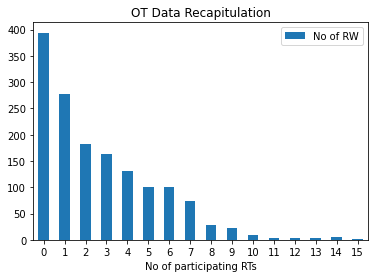

In [0]:
RTnRWrecap(rt_ot,"OT","w")

### Weekly Data

In [0]:
zeroRW_wk = zeroRW(rt_wk,"Weekly","a")
print(len(zeroRW_wk))
zeroRW_wk.head(2)

447


,IDDESA,Kecamatan,Kelurahan,RW,RT counts
1053,3374140005,Semarang Barat,Bojong Salaman,6,0
1054,3374140004,Semarang Barat,Bongsari,7,0


In [0]:
rw_wk = RWperKEL(rt_wk)
rw_wk.head(2)

,IDDESA,Kecamatan,Kelurahan,RW counts,RT counts,Actual RW,RW (%)
0,3374010001,Mijen,Cangkiran,8,21,8,100.0
1,3374010002,Mijen,Bubakan,2,4,5,40.0


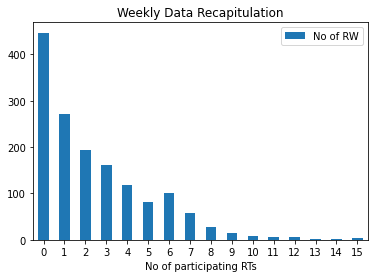

In [0]:
RTnRWrecap(rt_wk,"Weekly","a")

### Monthly Data

In [0]:
zeroRW_mt = zeroRW(rt_mt,"Weekly","a")
print(len(zeroRW_mt))
zeroRW_mt.head(2)

489


,IDDESA,Kecamatan,Kelurahan,RW,RT counts
1011,3374140005,Semarang Barat,Bojong Salaman,6,0
1012,3374140004,Semarang Barat,Bongsari,7,0


In [0]:
rw_mt = RWperKEL(rt_mt)
rw_mt.head(2)

,IDDESA,Kecamatan,Kelurahan,RW counts,RT counts,Actual RW,RW (%)
0,3374010001,Mijen,Cangkiran,7,15,8,87.5
1,3374010002,Mijen,Bubakan,1,3,5,20.0


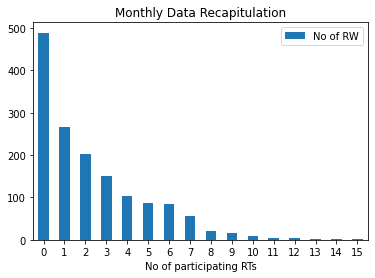

In [0]:
RTnRWrecap(rt_mt,"Monthly","a")

## Kelurahan's participation

### One Time Data

In [0]:
kel_ot = KelperKec(rw_ot)
kel_ot.head(2)

,,RW counts,RT counts,Actual RW,RW (%)
IDDESA,Kecamatan,,,,
3374010,Mijen,64,157,87,73.56
3374020,Gunungpati,85,271,97,87.63


### Weekly

In [0]:
kel_wk = KelperKec(rw_wk)
kel_wk.head(2)

,,RW counts,RT counts,Actual RW,RW (%)
IDDESA,Kecamatan,,,,
3374010,Mijen,59,146,87,67.82
3374020,Gunungpati,83,251,97,85.57


### Monthly

In [0]:
kel_mt = KelperKec(rw_mt)
kel_mt.head(2)

,,RW counts,RT counts,Actual RW,RW (%)
IDDESA,Kecamatan,,,,
3374010,Mijen,57,139,87,65.52
3374020,Gunungpati,82,248,97,84.54


## Save recapitulation file

In [0]:
recap_files = {"OT":{"RT":rt_ot,"RW":rw_ot,"kel":kel_ot},
               "Weekly":{"RT":rt_wk,"RW":rw_wk,"kel":kel_wk},
               "Monthly":{"RT":rt_mt,"RW":rw_mt,"kel":kel_mt}}
data_name = ["OT","Weekly","Monthly"]
level_com = ["RT","RW","kel"]

In [0]:
for data in data_name:
  for level in level_com:
    if data=="OT" and level=="RT":
      saver(recap_files[data][level],"Recap ",data+" "+level,'w')
    else:
      saver(recap_files[data][level],"Recap ",data+" "+level,'a')

# OT cleaning